In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging, tensorflow as tf
logging.getLogger("tensorflow").setLevel(logging.ERROR)
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Periods trained (single-output per period)
PERIOD_COLS = [
    "PGA_g","T0pt050S","T0pt075S","T0pt100S","T0pt150S","T0pt200S",
    "T0pt300S","T0pt500S","T0pt750S","T1pt000S","T1pt500S","T2pt000S",
    "T3pt000S"
]

T_map = {
    "PGA_g": 0.00, "T0pt050S": 0.05, "T0pt075S": 0.075, "T0pt100S": 0.10,
    "T0pt150S": 0.15, "T0pt200S": 0.20, "T0pt300S": 0.30, 
    "T0pt500S": 0.50, "T0pt750S": 0.75, "T1pt000S": 1.00, 
    "T1pt500S": 1.50, "T2pt000S": 2.00, "T3pt000S": 3.00    
}

# Feature list (must match training) - use the same input names
input_param = ["Earthquake_Magnitude", "JB_km" , "Vs30_Selected_for_Analysis_m_s"]

In [3]:
# Paths: adjust if different in your project
SCALER_PATH     = os.path.join("Models", "X_scaler.pkl")
MODEL_DIR  = os.path.join("Models")
MODEL_SUFFIX = "_transfer.keras" 

In [4]:
# Load scaler
with open(SCALER_PATH, "rb") as f:
    scaler = pickle.load(f)

# Plot Attenuation Curves

In [6]:
# ------------------------------------------------
# Periods: (column_name, label_for_title)
# ------------------------------------------------
period_spec = [
    ("PGA_g",    "PGA"),
    ("T0pt200S", "T = 0.2 s"),
    ("T1pt000S", "T = 1.0 s"),
    ("T2pt000S", "T = 2.0 s"),
]

# Filter to only periods that you want to plot
period_spec_filtered = []
models_att = {}

for col_name, label in period_spec:
    model_path = os.path.join(MODEL_DIR, f"{col_name}{MODEL_SUFFIX}")
    if os.path.isfile(model_path) and col_name in PERIOD_COLS:
        try:
            models_att[col_name] = tf.keras.models.load_model(model_path)
            period_spec_filtered.append((col_name, label))
            print(f"Loaded model for {col_name} from {model_path}")
        except Exception as e:
            print(f"[WARN] Could not load model for {col_name}: {e}")

period_spec = period_spec_filtered

if len(period_spec) == 0:
    raise RuntimeError("No attenuation models loaded. Check MODEL_DIR/MODEL_SUFFIX/period_spec.")

Loaded model for PGA_g from Models\PGA_g_transfer.keras
Loaded model for T0pt200S from Models\T0pt200S_transfer.keras
Loaded model for T1pt000S from Models\T1pt000S_transfer.keras
Loaded model for T2pt000S from Models\T2pt000S_transfer.keras


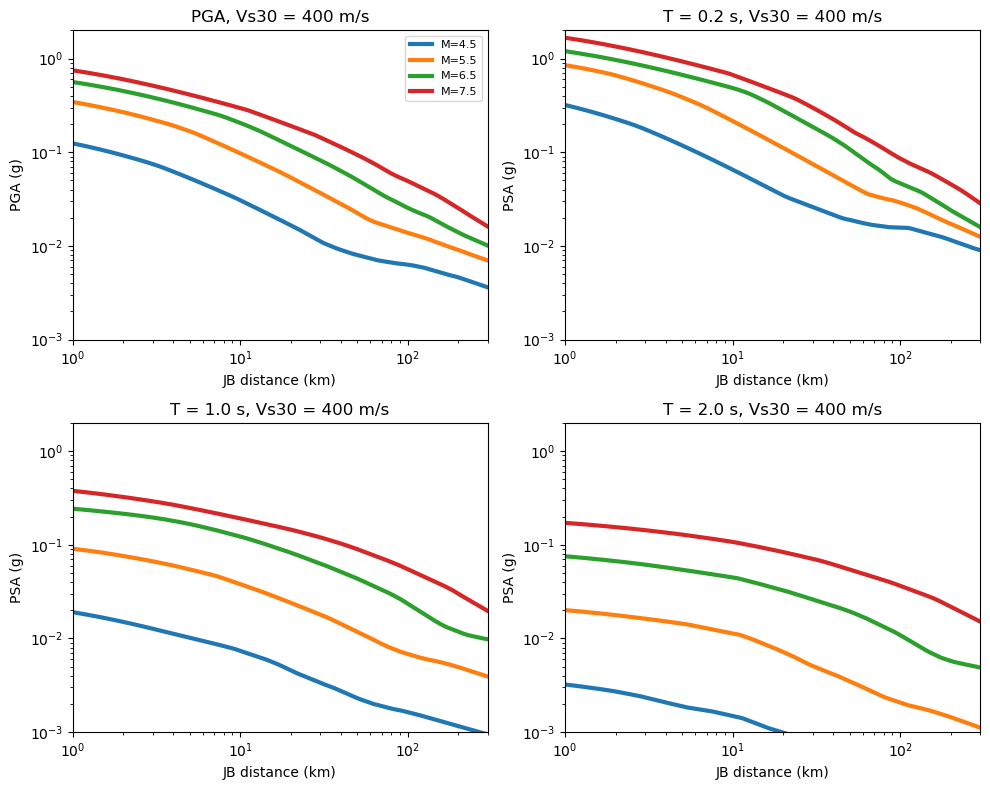

In [7]:
# ------------------------------------------------
# Distance range (km) for attenuation curves
# ------------------------------------------------
R_vals = np.logspace(0, 2.5, 200)  # 1–300 km
magnitudes  = [4.5, 5.5, 6.5, 7.5]
Vs30_for_plot = 400

# ------------------------------------------------
# single-output attenuation prediction
# ------------------------------------------------
def _predict_att_curve_single_output(model, M, Vs30, R_array):
    """
    Predict attenuation curve (PSA/PGA vs distance) for a single period
    using a SINGLE-OUTPUT model (ln y).
    """
    df = pd.DataFrame({
        "Earthquake_Magnitude": [M] * len(R_array),
        "JB_km" : R_array,
        "Vs30_Selected_for_Analysis_m_s": [Vs30] * len(R_array),
    })

    # Same feature transforms as in training
    df["JB_km" ] = np.log1p(df["JB_km" ])
    df["Vs30_Selected_for_Analysis_m_s"] = np.log1p(df["Vs30_Selected_for_Analysis_m_s"])

    X_sc = scaler.transform(df[input_param]).astype("float32")

    y_log = model.predict(X_sc, verbose=0).ravel()  # shape (n_R,)
    Sa = np.exp(y_log)                              # back to g
    return Sa

# ------------------------------------------------
# Make attenuation figure
# ------------------------------------------------
fig1, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for ax, (col_name, label) in zip(axes, period_spec):
    model_for_att = models_att[col_name]

    for M in magnitudes:
        Sa = _predict_att_curve_single_output(model_for_att, M, Vs30_for_plot, R_vals)
        ax.loglog(R_vals, Sa, linewidth=3, label=f"M={M}")

    region_str = "Iran (Transfer ANN)"
    ax.set_title(f"{label}, Vs30 = {Vs30_for_plot:.0f} m/s")
    ax.set_xlabel("JB distance (km)")
    ylabel = "PGA (g)" if col_name == "PGA_g" else "PSA (g)"
    ax.set_ylabel(ylabel)
    ax.set_xlim([1, 300])
    ax.set_ylim([1e-3, 2])

# Legend on first subplot
axes[0].legend(loc="best", fontsize=8)

plt.tight_layout()
plt.show()

# Response Spectra

In [9]:
# -------------------------------
# Load per-period models
# -------------------------------
models = {}
period_labels = []

for col in PERIOD_COLS:
    model_path = os.path.join(MODEL_DIR, f"{col}{MODEL_SUFFIX}")
    if os.path.isfile(model_path) and (col in T_map):
        try:
            models[col] = tf.keras.models.load_model(model_path)
            period_labels.append(col)
            print(f"Loaded model for {col} from {model_path}")
        except Exception as e:
            print(f"[WARN] Could not load {model_path}: {e}")

if not period_labels:
    raise RuntimeError("No models loaded – check MODEL_DIR and MODEL_SUFFIX.")

# For response spectra, better to avoid T=0 in log-log plots; drop PGA if present
period_labels = [p for p in period_labels if T_map[p] > 0.0]

# Sort by period value
period_labels = sorted(period_labels, key=lambda k: T_map[k])
T_vals = np.array([T_map[p] for p in period_labels], dtype=float)

print("\nUsing periods for response spectra:")
for p in period_labels:
    print(f"  {p}: T = {T_map[p]} s")

# -------------------------------
# predict spectrum
# -------------------------------
def predict_spectrum_single_output(M, R, Vs30):
    """
    Predict PSA(T) in g for all available periods using
    one single-output model per period.
    """
    df_input = pd.DataFrame({
        "Earthquake_Magnitude": [M],
        "JB_km": [R],
        "Vs30_Selected_for_Analysis_m_s": [Vs30],
    })

    # Same feature transforms as training
    df_input["JB_km"] = np.log1p(df_input["JB_km"])
    df_input["Vs30_Selected_for_Analysis_m_s"] = np.log1p(
        df_input["Vs30_Selected_for_Analysis_m_s"]
    )

    X_sc = scaler.transform(df_input[input_param]).astype("float32")

    Sa_vals = []
    for p in period_labels:
        m = models[p]
        y_log = m.predict(X_sc, verbose=0)[0, 0]  # scalar ln(PSA)
        Sa_vals.append(np.exp(y_log))             # back to linear g

    return np.array(Sa_vals, dtype=float)         # shape: (n_periods,)

Loaded model for PGA_g from Models\PGA_g_transfer.keras
Loaded model for T0pt050S from Models\T0pt050S_transfer.keras
Loaded model for T0pt075S from Models\T0pt075S_transfer.keras
Loaded model for T0pt100S from Models\T0pt100S_transfer.keras
Loaded model for T0pt150S from Models\T0pt150S_transfer.keras
Loaded model for T0pt200S from Models\T0pt200S_transfer.keras
Loaded model for T0pt300S from Models\T0pt300S_transfer.keras
Loaded model for T0pt500S from Models\T0pt500S_transfer.keras
Loaded model for T0pt750S from Models\T0pt750S_transfer.keras
Loaded model for T1pt000S from Models\T1pt000S_transfer.keras
Loaded model for T1pt500S from Models\T1pt500S_transfer.keras
Loaded model for T2pt000S from Models\T2pt000S_transfer.keras
Loaded model for T3pt000S from Models\T3pt000S_transfer.keras

Using periods for response spectra:
  T0pt050S: T = 0.05 s
  T0pt075S: T = 0.075 s
  T0pt100S: T = 0.1 s
  T0pt150S: T = 0.15 s
  T0pt200S: T = 0.2 s
  T0pt300S: T = 0.3 s
  T0pt500S: T = 0.5 s
  T0p

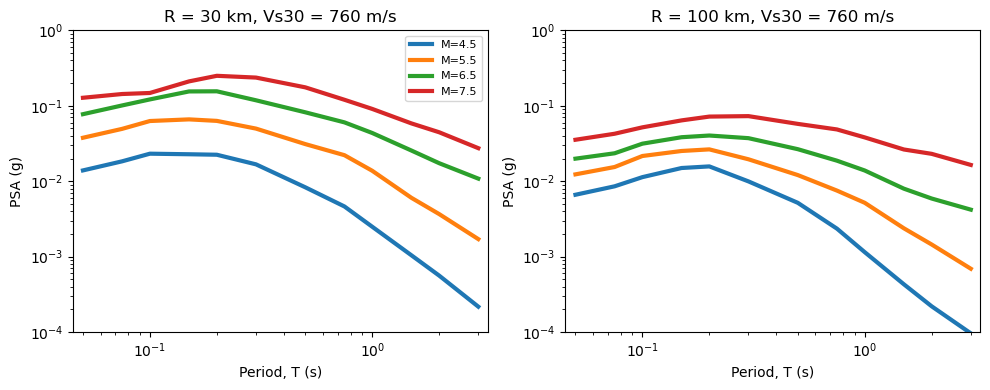

In [10]:
# -------------------------------
# Plot response spectra
# -------------------------------
magnitudes  = [4.5, 5.5, 6.5, 7.5]
distances   = [30.0, 100.0]  # km
Vs30_for_plot = 760

fig3, axes = plt.subplots(1, 2, figsize=(10, 4))
axes = axes.flatten()

for ax, R in zip(axes, distances):
    for M in magnitudes:
        Sa = predict_spectrum_single_output(M=M, R=R, Vs30=Vs30_for_plot)
        ax.loglog(T_vals, Sa, linewidth=3, label=f"M={M}")

    region_str = "Iran (Transfer ANN)"
    ax.set_title(f"R = {R:.0f} km, Vs30 = {Vs30_for_plot:.0f} m/s")
    ax.set_xlabel("Period, T (s)")
    ax.set_ylabel("PSA (g)")
    ax.set_xlim([max(1e-2, T_vals.min()*0.9), T_vals.max()*1.1])
    ax.set_ylim([1e-4, 1])

# Single legend
axes[0].legend(loc="best", fontsize=8)

plt.tight_layout()
plt.show()